### SET UP ENVIRONMENT

In [ ]:
!pip install -r ../dev-requirements.txt

In [ ]:
# Load .env file if it exists
# Don't use dotenv
!pip install python-dotenv

from dotenv import load_dotenv
load_dotenv('../.env')

### LOAD DATA

In [ ]:
import pandas as pd
import os


folder = os.path.join("../../airflow/assets/binance_1d")
dfs = []
for file in os.listdir(folder):
    if file.endswith(".csv"):
        dfs.append(pd.read_csv(os.path.join(folder, file), skiprows=1, parse_dates=['Date']))
print(dfs.__len__())

#### Merge all in one dataframe

In [ ]:
import pandas as pd

# Step 1: Convert "date" column to datetime in all dataframes
for df in dfs:
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors="coerce")

# Step 2: Find the oldest and newest dates across all dataframes
all_dates = [df['Date'] for df in dfs]
all_dates_flat = [date for sublist in all_dates for date in sublist if not pd.isnull(date)]

oldest_date = '2019-01-01'
newest_date = max(all_dates_flat)

# Step 3: Create a new dataframe with the date range
date_range = pd.date_range(start=oldest_date, end=newest_date, freq='D')  # Daily frequency
merged_df = pd.DataFrame({'Date': date_range})

# Step 4: Add "close" and "Volume USDT" columns from each dataframe to the merged_df using list comprehension
for df in dfs:
    try:
        ticker = df['Symbol'].iloc[0]  # Assuming each dataframe has a "symbol" column
        close_col_name = f'close_{ticker}'
        volume_col_name = f'Volume USDT_{ticker}'  # Replace with the actual column name if it's different in your data

        df = df.set_index('Date').sort_index()

        # Create DataFrames with the "date" and "close" columns
        close_data = df[df.index.isin(date_range)][['Close']]
        close_data.rename(columns={'Close': close_col_name}, inplace=True)

        # Merge the "close_data" into the "merged_df"
        merged_df = pd.merge(merged_df, close_data, left_on='Date', right_index=True, how='left')

        # Add the "Volume USDT" column to the merged_df (replace 'Volume USDT' with the actual column name if it's different)
        # merged_df[volume_col_name] = df['Volume USDT']

    except ValueError as e:
        print(f'Error on coin {ticker}: {e}')


# print number of columns -1 of merged_df
print(merged_df.columns.__len__()-1)

### LOAD Experiment from MLFLOW

Run 

``` python
cd mlflow
mlflow server
```

In [ ]:
import mlflow
import json

experiment_id = "110357928989408424"
run_id = "35f1bb80732f433297fda78e6638feab"

# Mlfow Section
experiments = mlflow.search_runs(experiment_ids=experiment_id)
experiment = experiments.loc[experiments['run_id'] == run_id]

# Use eval() to convert the string to a list of tuples
data_list = eval(experiment["params.Cluster_Labels"].tolist()[0])

# Convert the list of tuples to a dictionary
data_dict = dict(data_list)

# Create a map where keys are the values from the original dictionary
cripto_clusters = {}
for key, value in data_dict.items():
    if value in cripto_clusters:
        cripto_clusters[value].append(key)
    else:
        cripto_clusters[value] = [key]

clusters_data = {}

# loop on key and value of cripto_clusters
for cluster, criptos in cripto_clusters.items():
    _criptos = criptos + ['Date']
    clusters_data[cluster] = merged_df[_criptos]

# Clusters now contains a dictionary with the cluster number as key and the dataframe with the criptos as value

### MODELS SECTION

#### Data analysis

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(time_series, significance_level=0.05):
    """
    Perform Augmented Dickey-Fuller (ADF) test for stationarity.

    Parameters:
    - time_series: A pandas Series or NumPy array containing the time series data.
    - significance_level: The significance level for the test (default is 0.05).

    Returns:
    - ADF test result and p-value.
    - A string indicating the stationarity based on the p-value.
    """

    result = adfuller(time_series)
    adf_statistic = result[0]
    p_value = result[1]

    if p_value <= significance_level:
        stationarity = "Stationary (p <= {0})".format(significance_level)
    else:
        stationarity = "Non-Stationary (p > {0})".format(significance_level)

    return adf_statistic, p_value, stationarity

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_and_plot_price_changes(cluster_data, column_name, window_size=10):
    """
    Calculate and plot first-order percentage differences, rolling mean, and rolling standard deviation.

    Parameters:
    - data: A pandas DataFrame containing a 'date' index and the specified cryptocurrency price column.
    - column_name: The name of the column representing cryptocurrency prices.
    - window_size: The window size for the rolling statistics (default is 10).

    Returns:
    - None (plots the results).
    """
    data = cluster_data.copy()
    if 'Date' not in data.columns:
        raise ValueError("The 'data' DataFrame must contain a 'date' column as the index.")

    if column_name not in data.columns:
        raise ValueError(f"The specified column '{column_name}' is not found in the DataFrame.")
    
    # Calculate daily percentage changes
    data['PriceChange'] = data[column_name].pct_change() * 100

    # Calculate rolling mean and rolling standard deviation
    data['RollingMean'] = data['PriceChange'].rolling(window=window_size).mean()
    data['RollingStd'] = data['PriceChange'].rolling(window=window_size).std()

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['PriceChange'], label='Price Change (%)', color='blue')
    plt.plot(data.index, data['RollingMean'], label=f'Rolling Mean ({window_size}-hour)', color='green')
    plt.plot(data.index, data['RollingStd'], label=f'Rolling Std Deviation ({window_size}-hour)', color='red')

    plt.xlabel('Date')
    plt.ylabel('Percentage Change / Rolling Statistics')
    plt.title(f'{column_name} Price Changes and Rolling Statistics')
    plt.legend()
    plt.grid(True)

    plt.show()

In [ ]:
for cluster in cripto_clusters:
    print(f'Cluster {cluster}: {cripto_clusters[cluster]}\n')
    for cripto in clusters_data[cluster]:
        if cripto != 'Date':
            print(f'Analyzing: {cripto}')

            adf_statistic, p_value, stationarity = adfuller_test(clusters_data[cluster][cripto])
            print("ADF Statistic:", adf_statistic)
            print("p-value:", p_value)
            print("Stationarity:", stationarity)

            calculate_and_plot_price_changes(clusters_data[cluster], cripto)
            print("\n")
        print("\n---------------------------------\n")

#### Multivariate Time Series - Vector Auto Regression (VAR)

[Source](https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/)

In [222]:
from math import sqrt
import os

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.var_model import VAR

import mlflow

def mts_var_training(cluster_data, 
                     apply_differencing: bool = False,
                     max_lag: int = 10):
    
    experiment_name = f"Training Binance 1D - 3 Cluster"
    mlflow.set_experiment(experiment_name)

    train, valid, test = data_preparation(cluster_data, apply_differencing)
    cols = cluster_data.columns.drop('Date')

    
    with mlflow.start_run():

        # Log parameters to MLflow
        mlflow.log_params({
            "Training_Model": "VAR",
            "Diff": apply_differencing,
            "Max_Lag": max_lag,
            "Criptos": cols
        })

        model_fit, order, trend, aic = find_best_model(train, max_lag)

        # make prediction on validation
        prediction = model_fit.forecast(model_fit.endog, steps=len(valid))

        #converting predictions to dataframe
        pred = pd.DataFrame(index=range(0, len(prediction)), columns=[cols]) 
        for j in range(0, len(cols)):
            for i in range(0, len(prediction)):
                pred.iloc[i, j] = prediction[i][j]

        #check rmse
        for cripto in cols:
            preds = pred[cripto]
            valids = valid[cripto]

            df = pd.DataFrame()
            df['pred'] = preds
            df['valid'] = valids.values
            df.index = valids.index

            rmse = sqrt(mean_squared_error(preds, valids))
            print('RMSE value for', cripto, 'is : ', rmse)
            mlflow.log_param(f"RMSE_{cripto.split('_')[1]}", rmse)

            # Create a plot and specify colors for each time series                     
            plot_path = f"{cripto}_prediction_plot.png"
            plt.figure(figsize=(10, 6))
            plt.plot(df['pred'], label='Predictions', color='blue')
            plt.plot(df['valid'], label='Actual', color='red')

            # Add labels, title, and legend
            plt.xlabel('Time')
            plt.ylabel('Value')
            plt.title('Two Time Series')
            plt.legend(loc='upper right')

            plt.annotate(f"RMSE: {rmse}", xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)

            plt.savefig(plot_path)
            plt.show()
            mlflow.log_artifact(plot_path)
            os.remove(plot_path)

        mlflow.log_params({
            "Order": order,
            "Trend": trend,
            "AIC": aic
        })
    mlflow.end_run()
    
    return pred, valid


def find_best_model(train_data,
                    max_lag,
                    trends=['c', 'ct', 'ctt', 'n']):
    best_order = None
    best_aic = float('inf')  # Initialize with positive infinity
    best_model = None
    best_trend = None

    for p in range(1, max_lag + 1):
        for trend in trends:
            # Fit a VAR model with the specified lag order and trend
            model = VAR(train_data)
            model_fit = model.fit(p, trend)
            
            # Calculate AIC for the current model
            current_aic = model_fit.aic
            
            # Check if the current AIC is the lowest so far
            if current_aic < best_aic:
                best_aic = current_aic
                best_order = p
                best_model = model_fit
                best_trend = trend
    
    print('Best lag order:', best_order)
    print('Best trend:', best_trend)
    print('Best AIC:', best_aic)

    return best_model, best_order, best_trend, best_aic


def data_preparation(cluster_data,
                     apply_differencing=False):
    # Data preparation
    
    # Step 1: Remove the "date" column
    data = cluster_data.drop(['Date'], axis=1)

    if apply_differencing:
        data = data.diff().dropna()
        # Step 2: Set the "date" column as the index
        data.index = pd.to_datetime(cluster_data.Date.iloc[1:], format='%Y-%m-%d')  # Modify the format as needed
    else:
        # Step 2: Set the "date" column as the index
        data.index = pd.to_datetime(cluster_data.Date, format='%Y-%m-%d')  # Modify the format as needed

    data = data.asfreq('D')  # Specify the frequency as 'D' for daily data

    # Step 3: Dealing with missing values --> already done

    # Step 4: Split the data into train and test sets
    train_size = int(len(data) * 0.7)
    test_size = (len(data) - train_size) / 2

    train = data.iloc[0:train_size] 
    valid = data.iloc[train_size:int(len(data) - test_size)]
    test = data.iloc[int(train_size + test_size):len(data)]

    # print('train size: ', len(train))
    # print('valid size: ', len(valid))
    # print('test size: ', len(test))
    # print('total size: ', len(data))
    # print("\n")
    assert len(data) == len(train) + len(valid) + len(test)

    return train, valid, test


Cluster 2: ['close_ETHUSDT', 'close_BNBUSDT', 'close_BTCUSDT', 'close_TRXUSDT']

Best lag order: 2
Best trend: c
Best AIC: 14.878718188897835
RMSE value for close_ETHUSDT is :  358.3761911351861


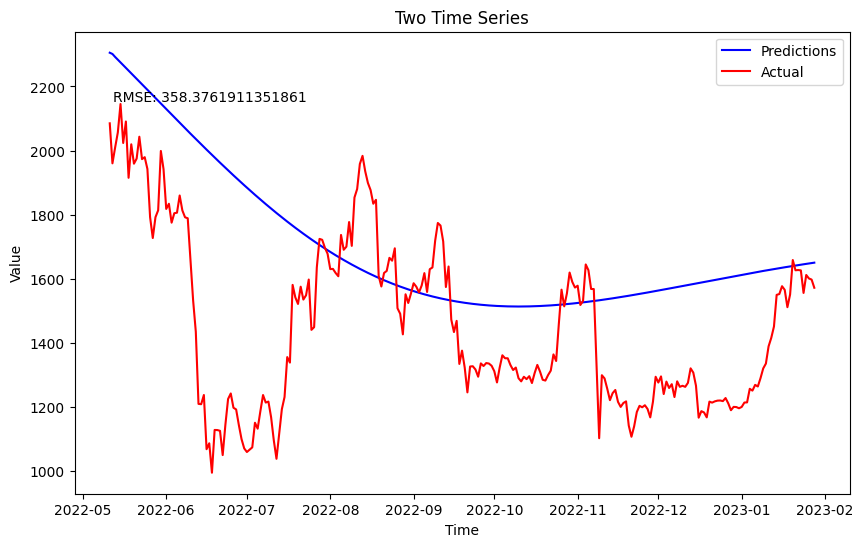

RMSE value for close_BNBUSDT is :  77.1428225162039


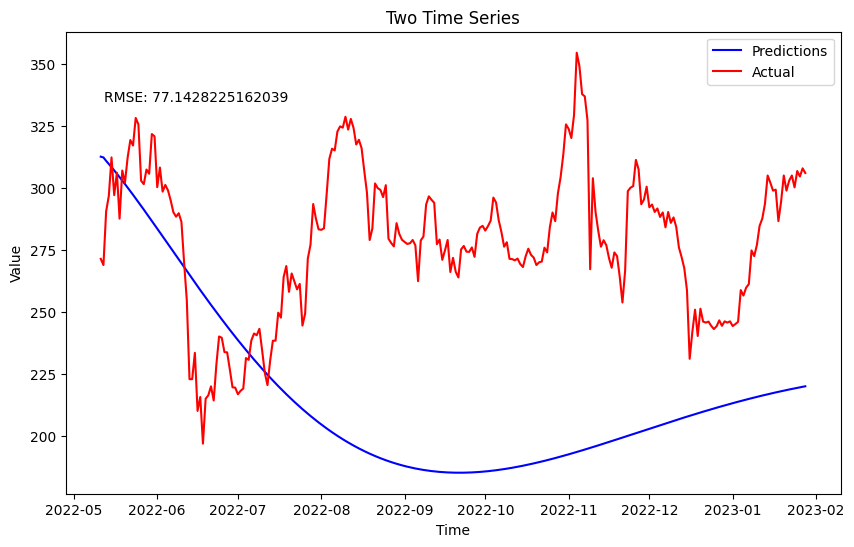

RMSE value for close_BTCUSDT is :  6960.44983211257


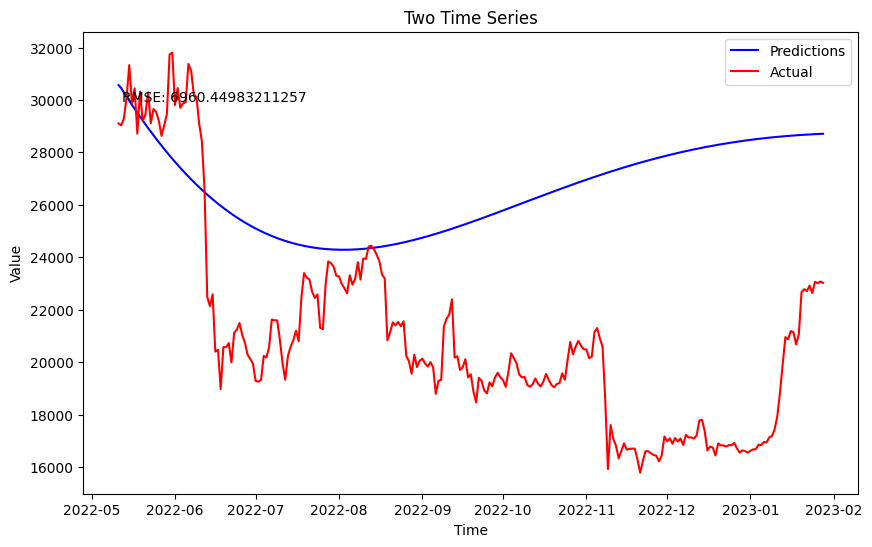

RMSE value for close_TRXUSDT is :  0.01583037778925924


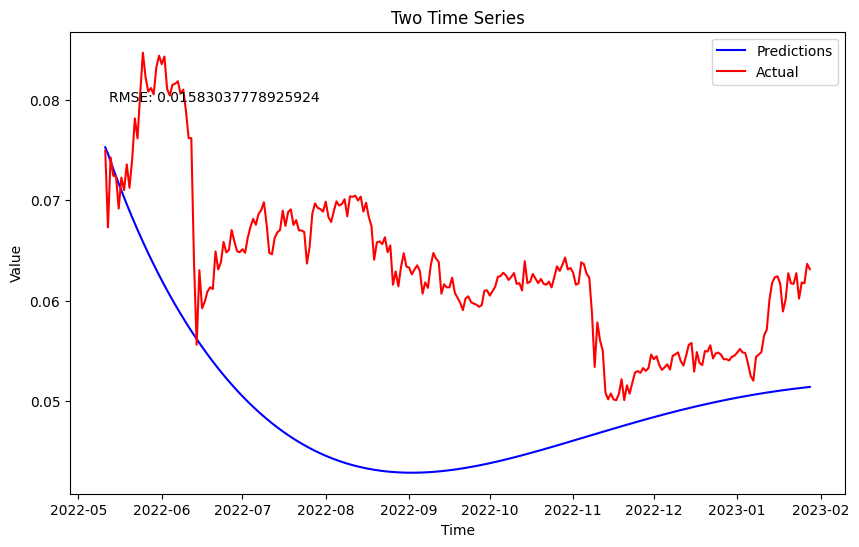


---------------------------------

Cluster 0: ['close_QTUMUSDT', 'close_VETUSDT', 'close_XRPUSDT', 'close_XLMUSDT', 'close_ICXUSDT', 'close_IOTAUSDT', 'close_ADAUSDT', 'close_ETCUSDT', 'close_NEOUSDT', 'close_LTCUSDT']

Best lag order: 2
Best trend: c
Best AIC: -43.19895956419318
RMSE value for close_QTUMUSDT is :  2.2503384936347075


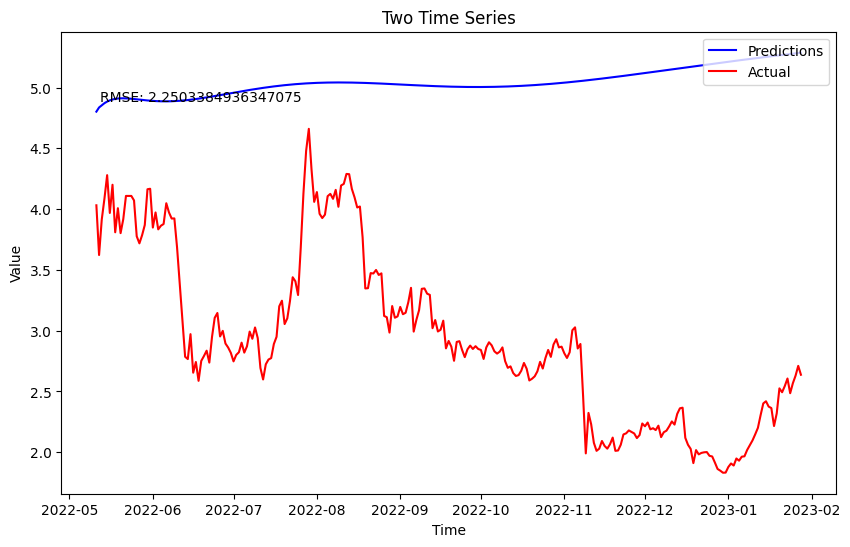

RMSE value for close_VETUSDT is :  0.017122082721553352


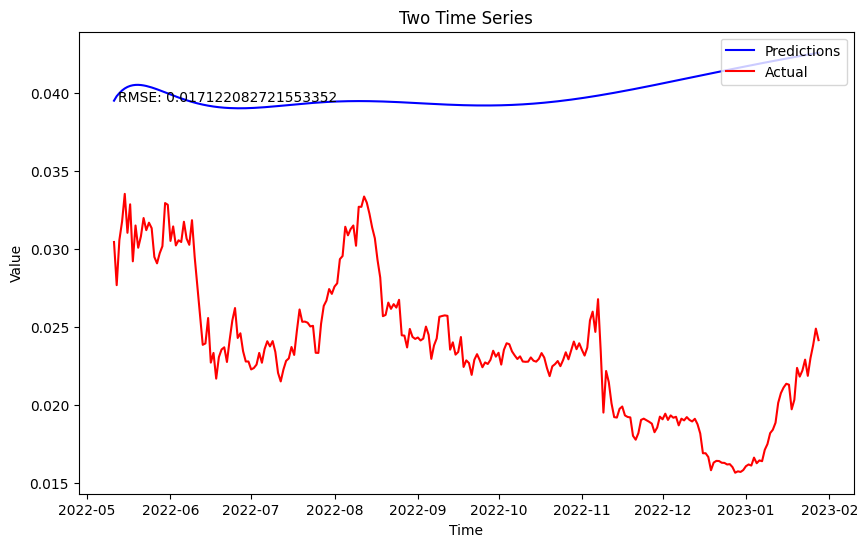

RMSE value for close_XRPUSDT is :  0.11889154161537155


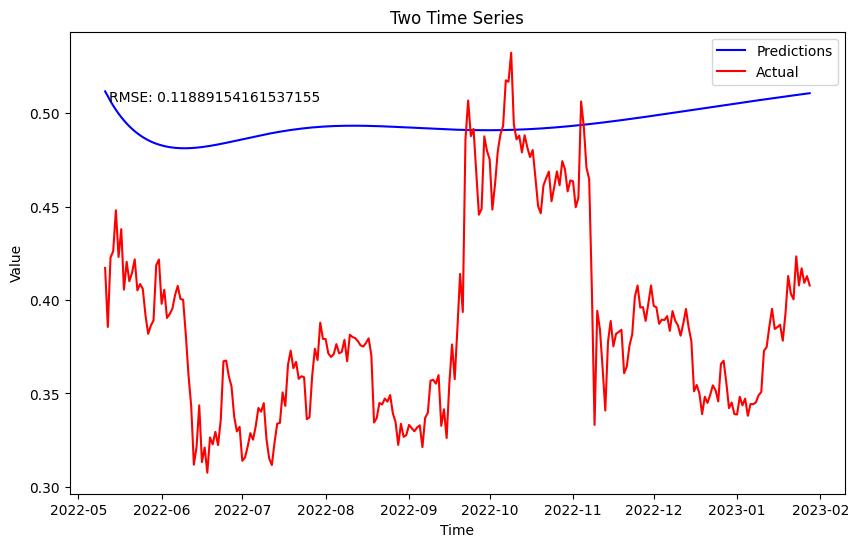

RMSE value for close_XLMUSDT is :  0.06701953893273857


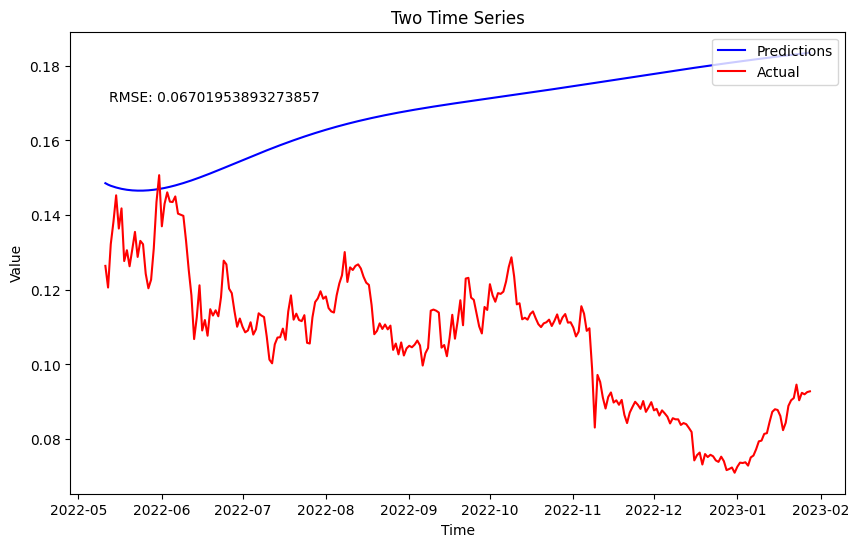

RMSE value for close_ICXUSDT is :  0.44549021083897955


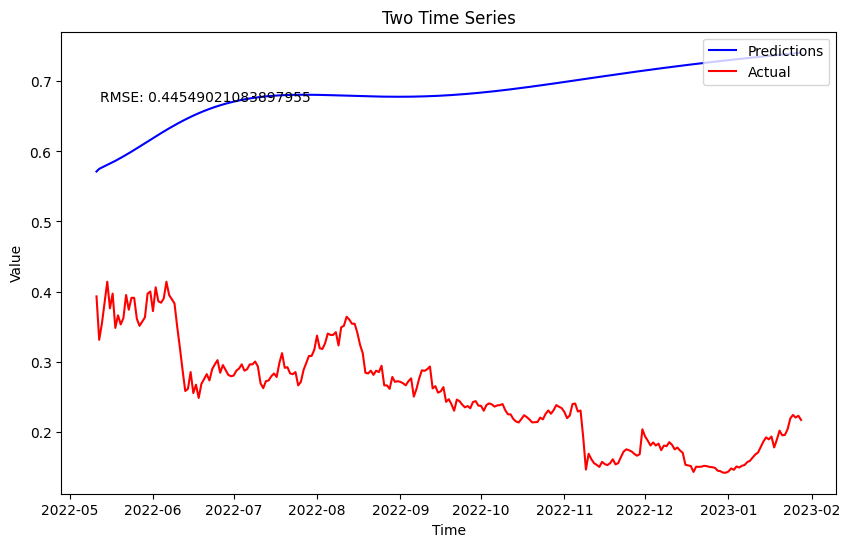

RMSE value for close_IOTAUSDT is :  0.3177305305640294


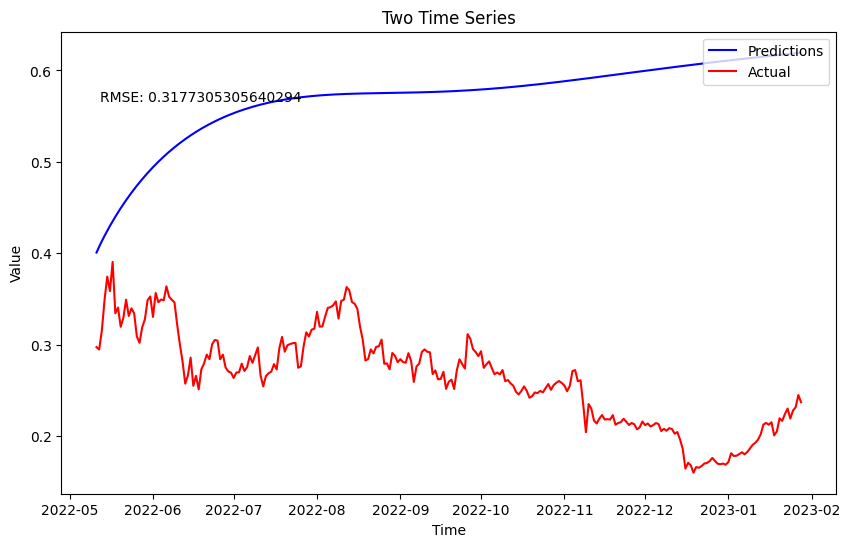

RMSE value for close_ADAUSDT is :  0.18728005570511036


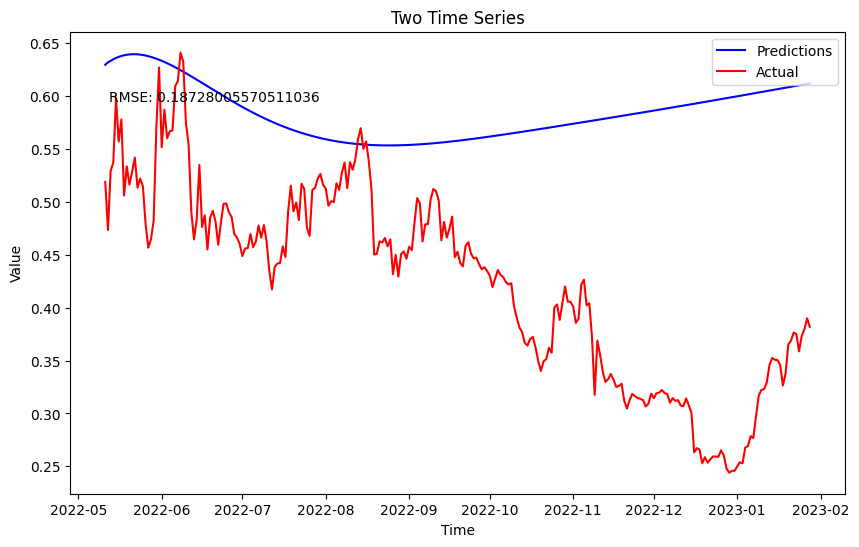

RMSE value for close_ETCUSDT is :  9.093067135205596


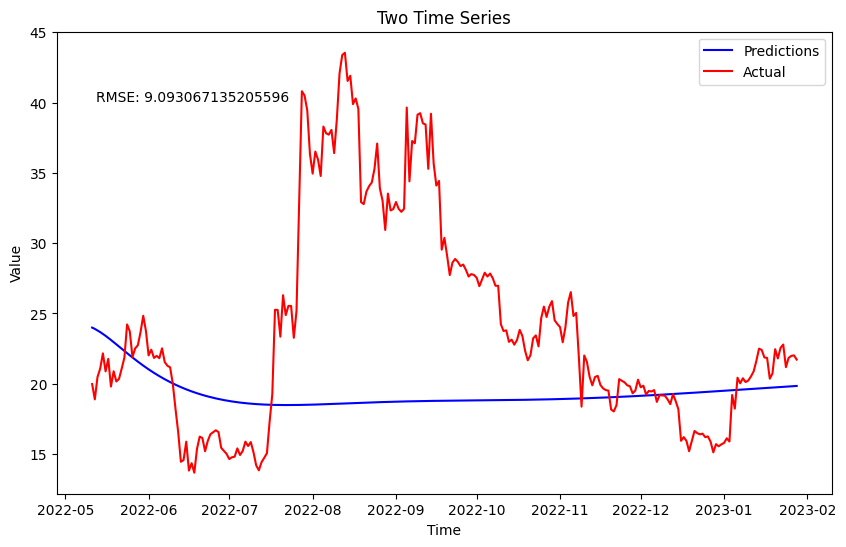

RMSE value for close_NEOUSDT is :  12.556570008734756


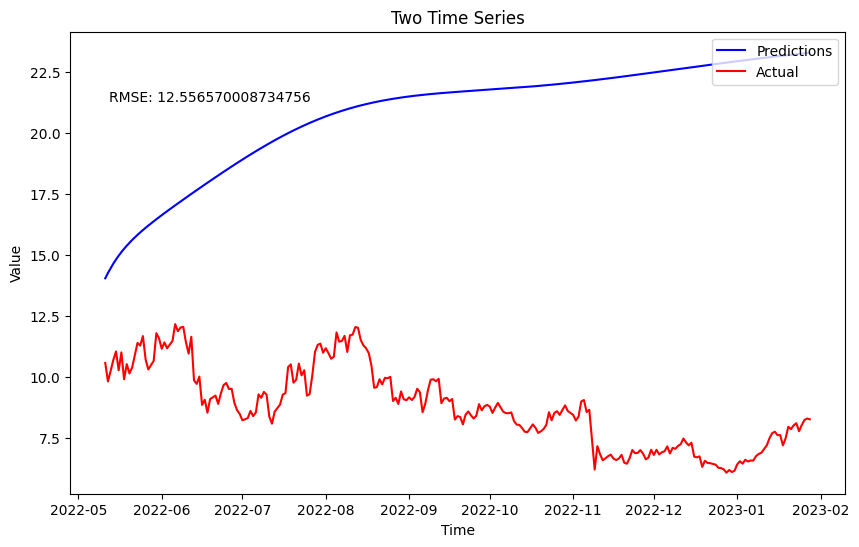

RMSE value for close_LTCUSDT is :  39.472102589243796


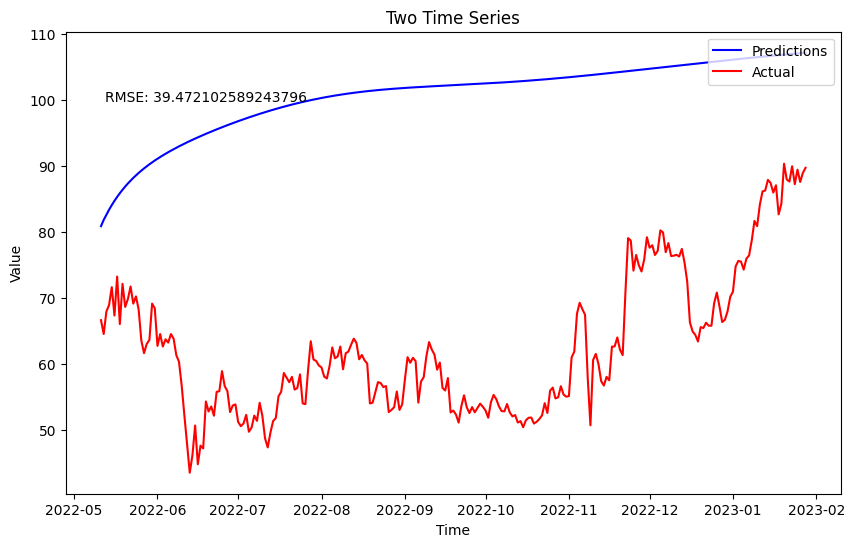


---------------------------------

Cluster 1: ['close_EOSUSDT', 'close_ONTUSDT', 'close_NULSUSDT']

Best lag order: 2
Best trend: c
Best AIC: -15.269160424745039
RMSE value for close_EOSUSDT is :  2.1759648049379883


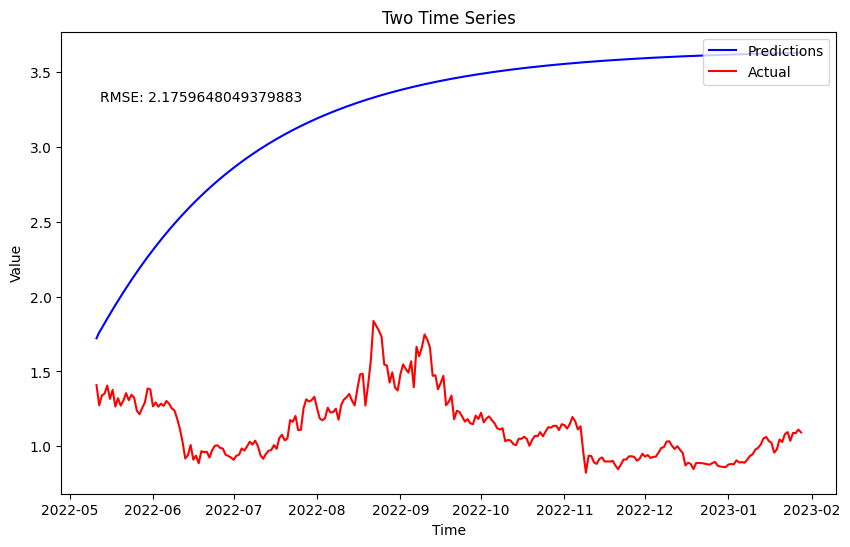

RMSE value for close_ONTUSDT is :  0.5119618333788525


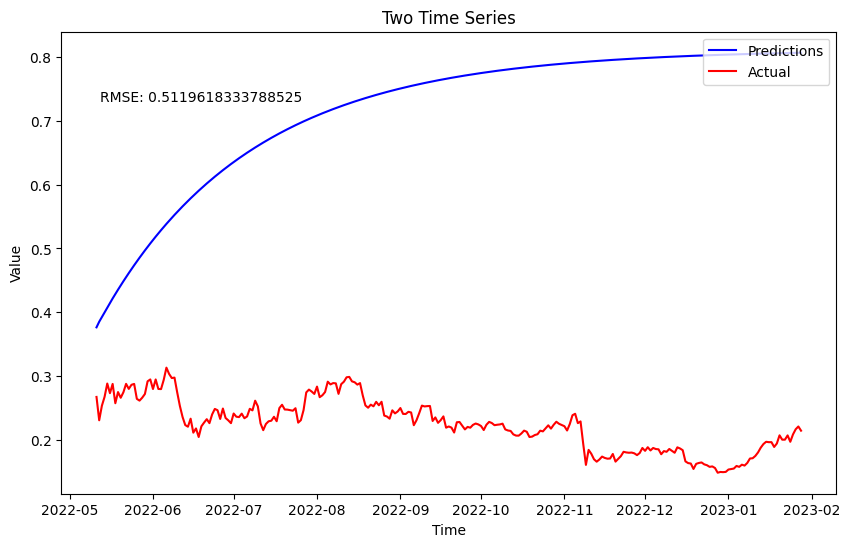

RMSE value for close_NULSUSDT is :  0.23644220007621092


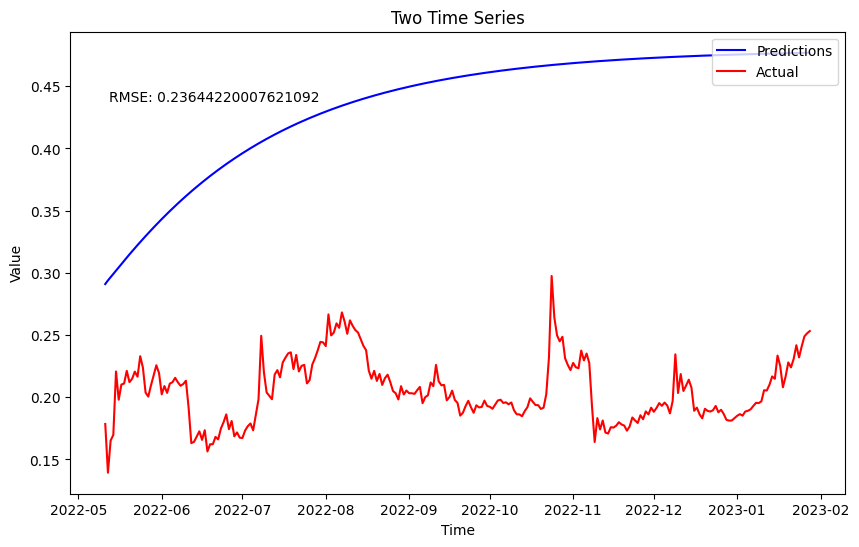


---------------------------------



In [223]:
for cluster in cripto_clusters:
    print(f'Cluster {cluster}: {cripto_clusters[cluster]}\n')

    pred, valid = mts_var_training(clusters_data[cluster],
                     apply_differencing=False, 
                     max_lag=2)

    print("\n---------------------------------\n")

Cluster 2: ['close_ETHUSDT', 'close_BNBUSDT', 'close_BTCUSDT', 'close_TRXUSDT']

Best lag order: 2
Best trend: c
Best AIC: 14.914528507221023
RMSE value for close_ETHUSDT is :  68.80688947566264


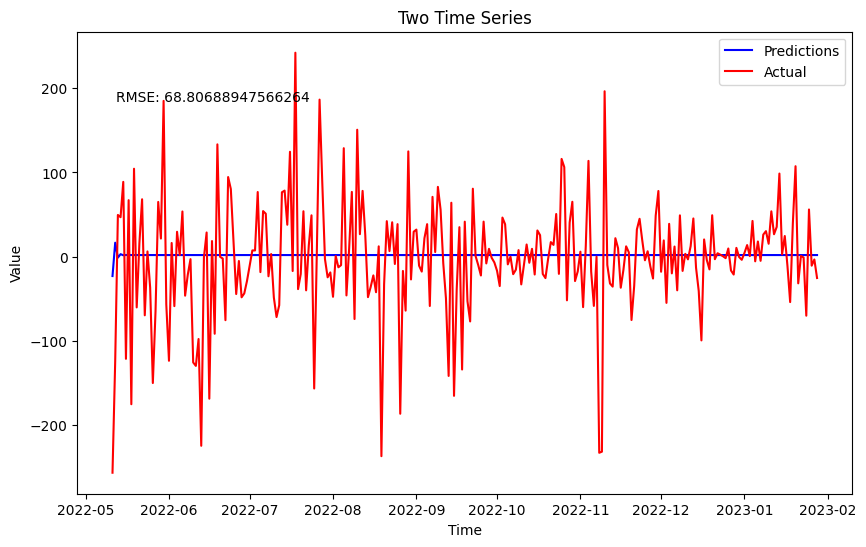

RMSE value for close_BNBUSDT is :  10.009403696038454


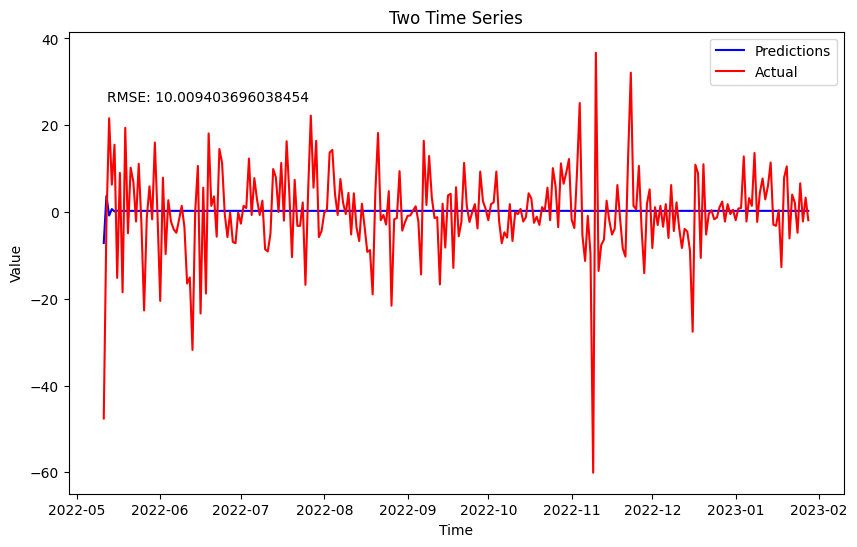

RMSE value for close_BTCUSDT is :  714.8187828442326


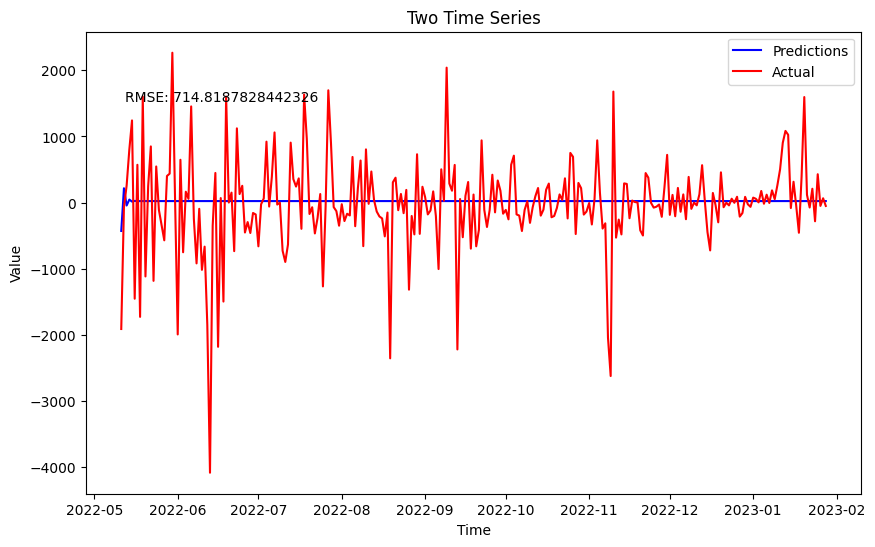

RMSE value for close_TRXUSDT is :  0.0019074397791152148


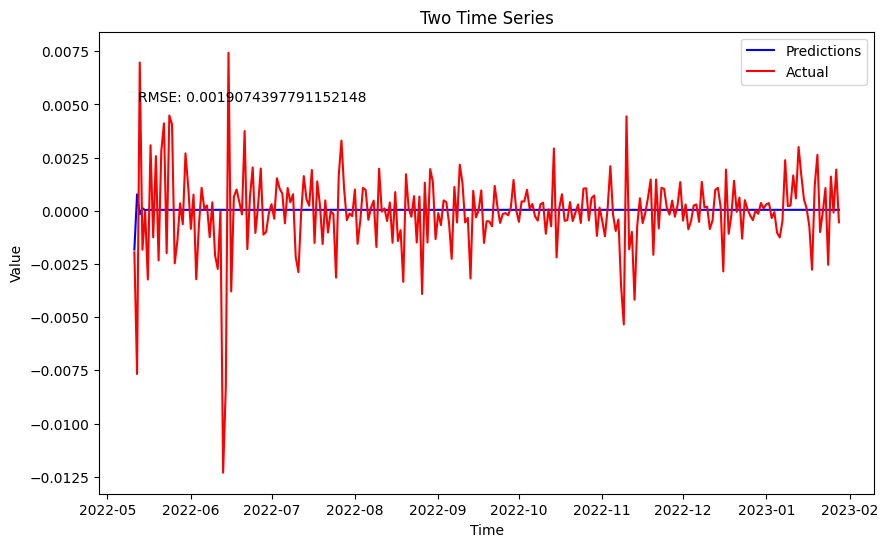


---------------------------------

Cluster 0: ['close_QTUMUSDT', 'close_VETUSDT', 'close_XRPUSDT', 'close_XLMUSDT', 'close_ICXUSDT', 'close_IOTAUSDT', 'close_ADAUSDT', 'close_ETCUSDT', 'close_NEOUSDT', 'close_LTCUSDT']

Best lag order: 2
Best trend: c
Best AIC: -43.36186184459898
RMSE value for close_QTUMUSDT is :  0.14055719903577277


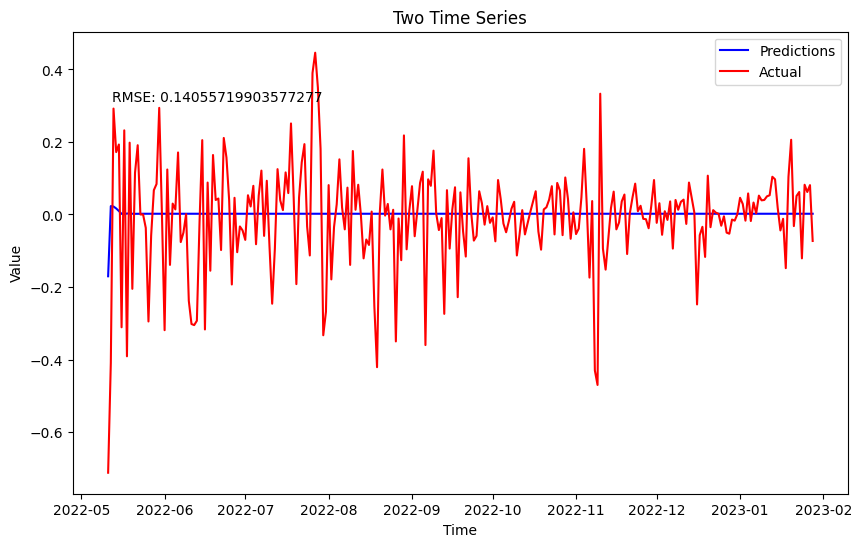

RMSE value for close_VETUSDT is :  0.0011463294422903675


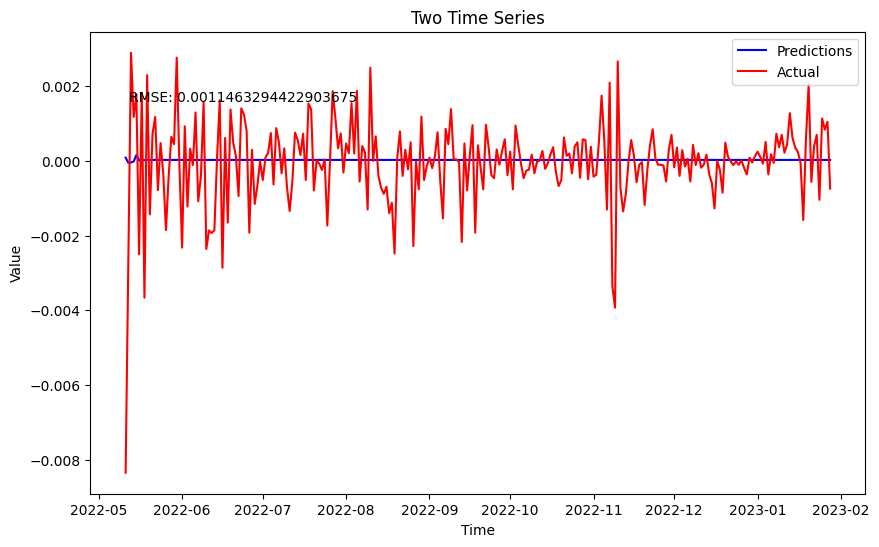

RMSE value for close_XRPUSDT is :  0.017171754881850455


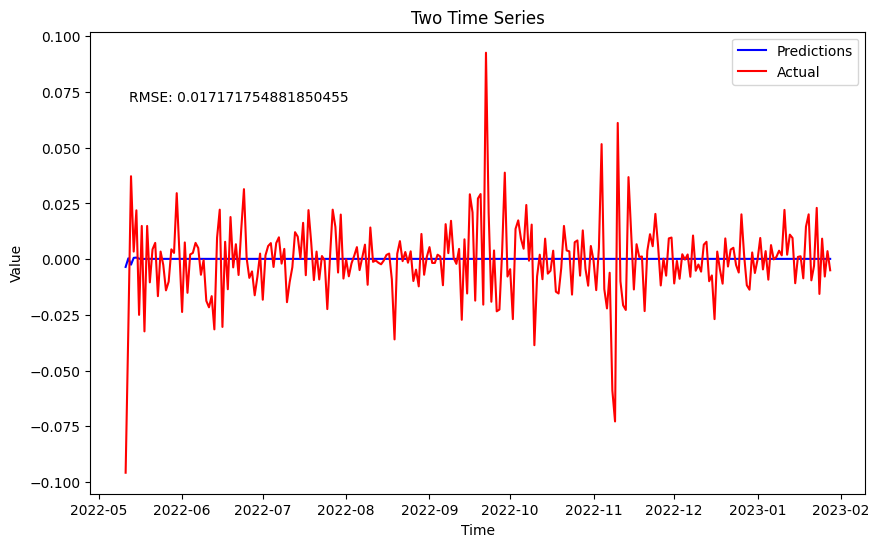

RMSE value for close_XLMUSDT is :  0.004449507612604937


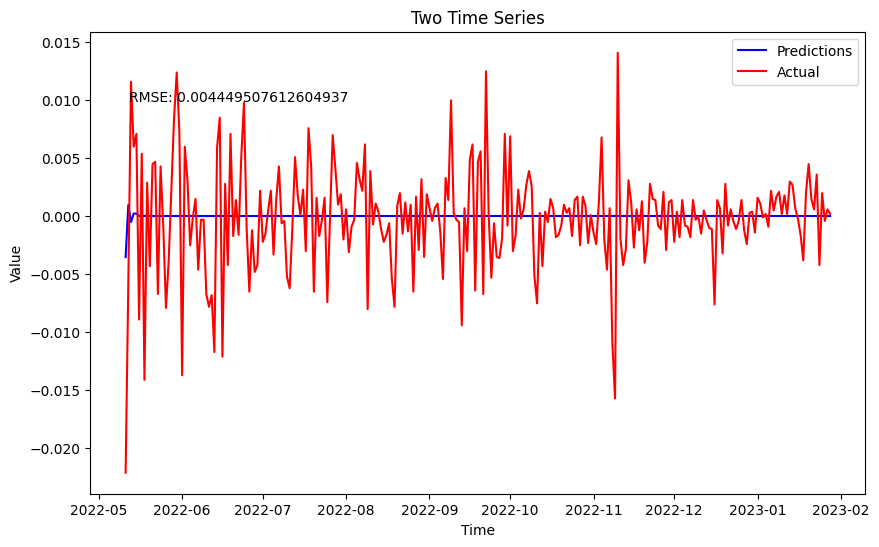

RMSE value for close_ICXUSDT is :  0.01661987927621924


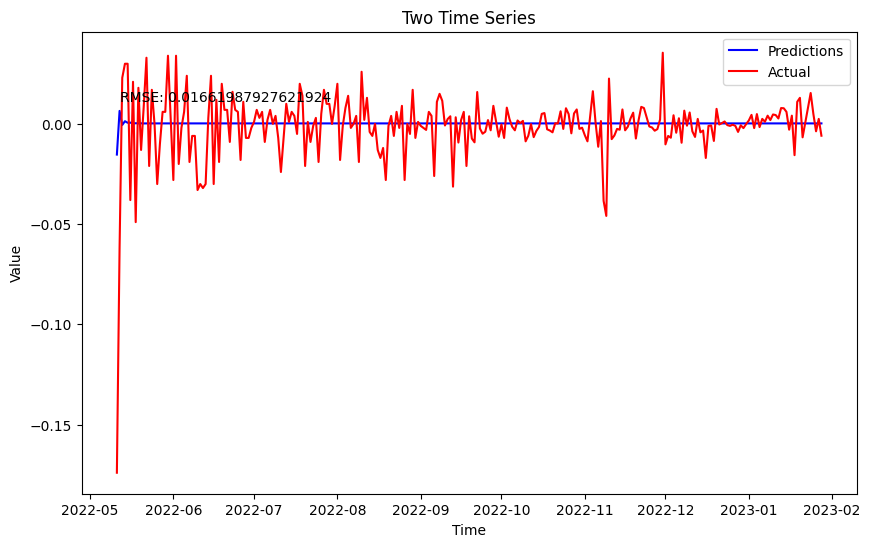

RMSE value for close_IOTAUSDT is :  0.012852073689153478


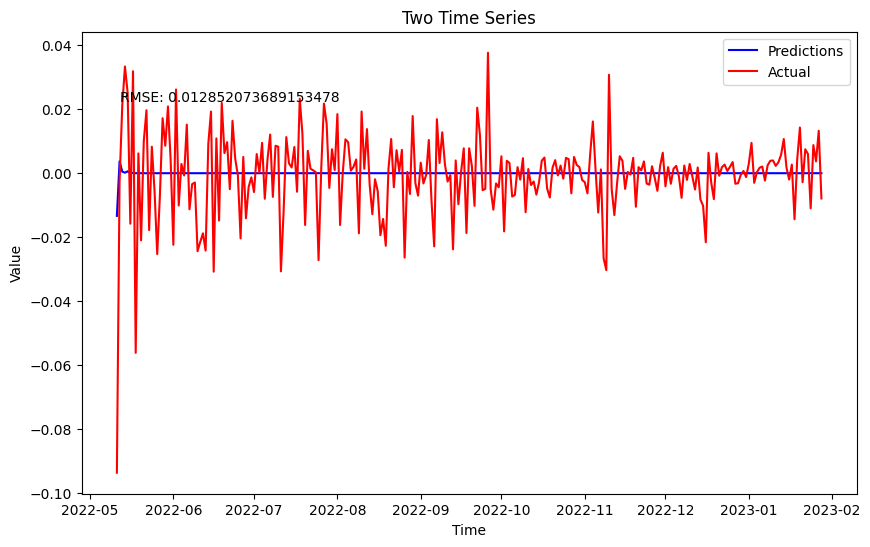

RMSE value for close_ADAUSDT is :  0.021568157438426865


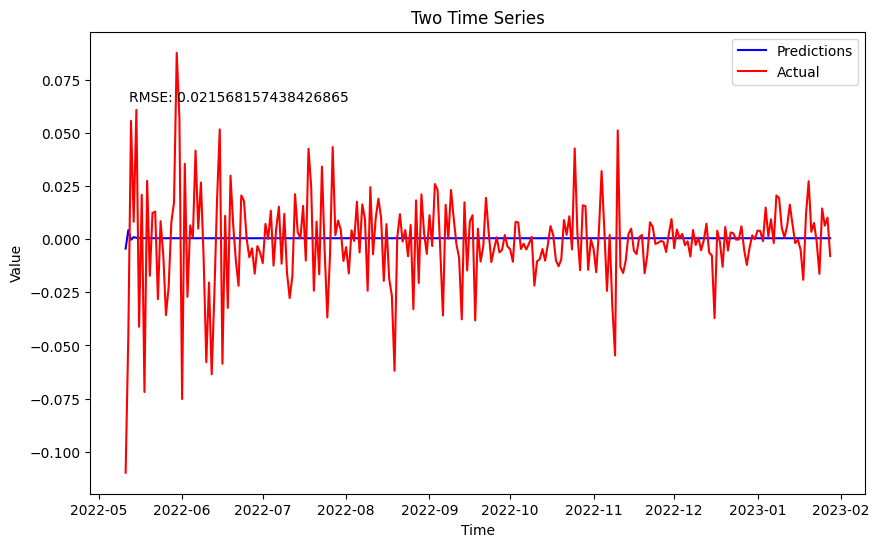

RMSE value for close_ETCUSDT is :  1.6020892946342382


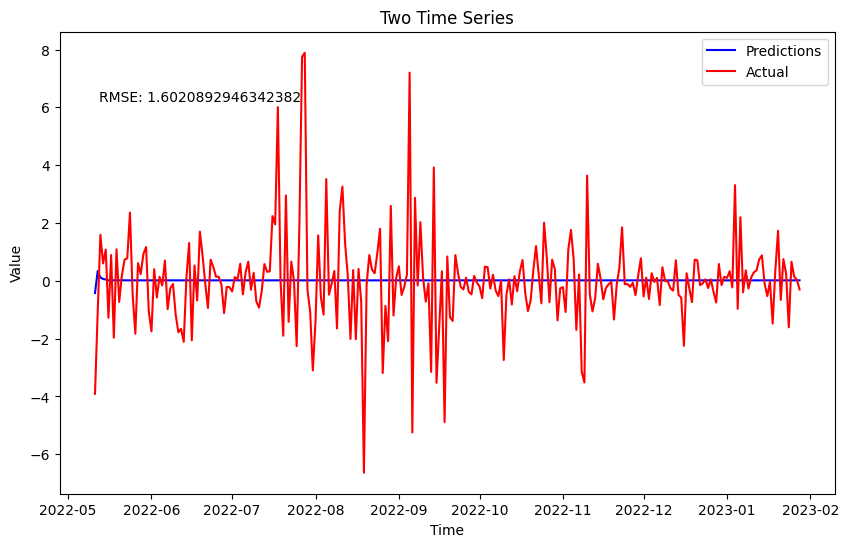

RMSE value for close_NEOUSDT is :  0.4249897729002097


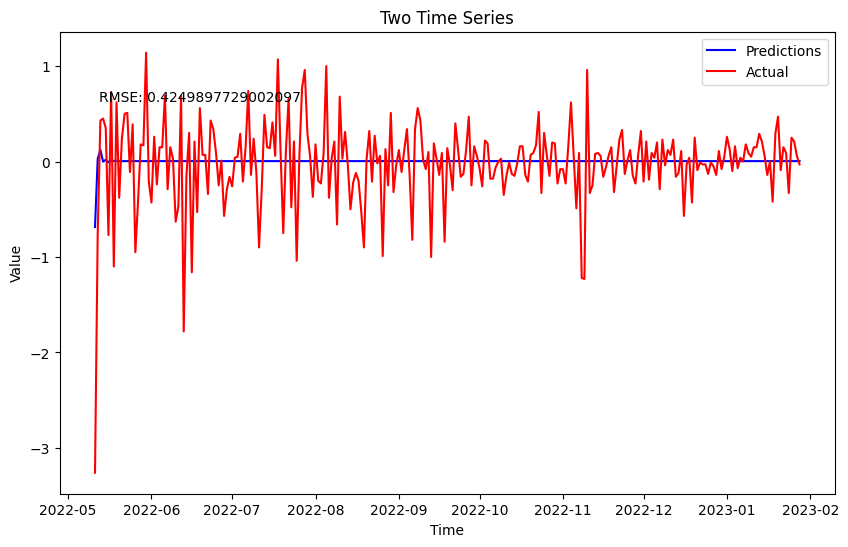

RMSE value for close_LTCUSDT is :  2.773481901567811


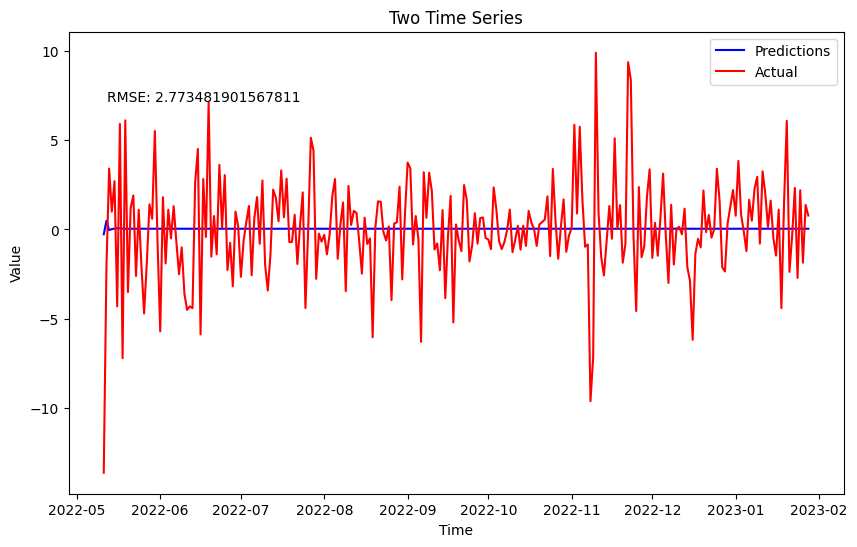


---------------------------------

Cluster 1: ['close_EOSUSDT', 'close_ONTUSDT', 'close_NULSUSDT']

Best lag order: 2
Best trend: c
Best AIC: -15.276145313313148
RMSE value for close_EOSUSDT is :  0.06296172731216398


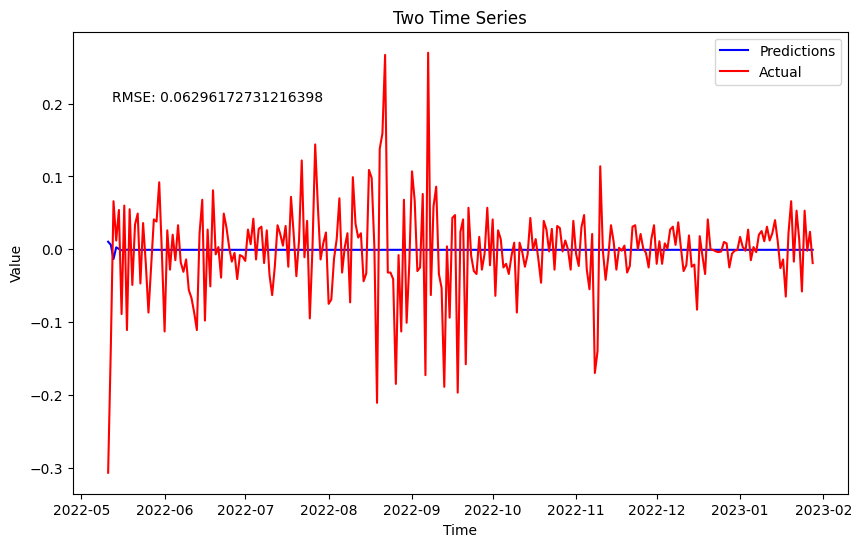

RMSE value for close_ONTUSDT is :  0.011860633252781921


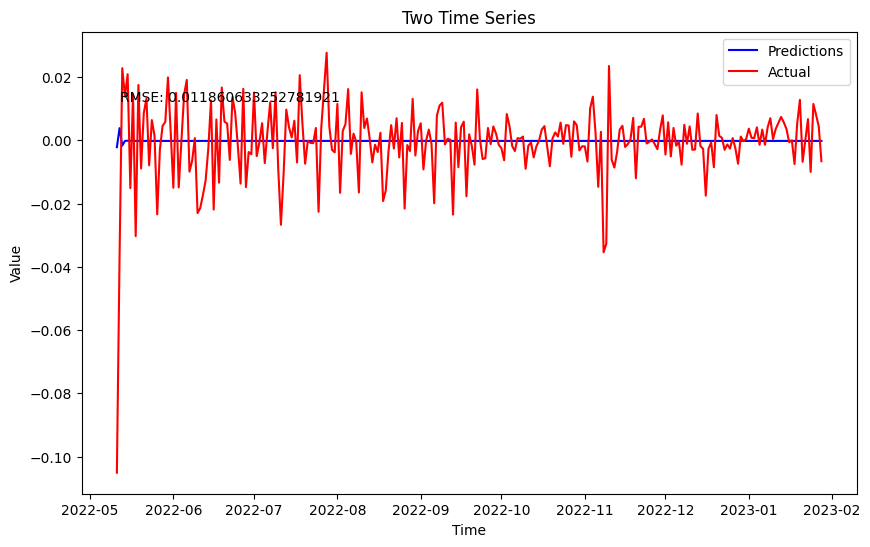

RMSE value for close_NULSUSDT is :  0.013692523982979956


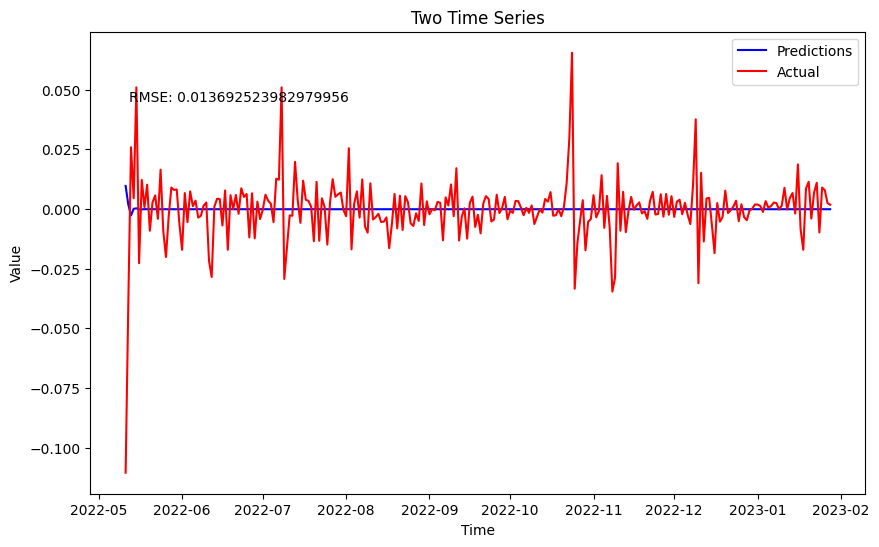


---------------------------------



In [224]:
for cluster in cripto_clusters:
    print(f'Cluster {cluster}: {cripto_clusters[cluster]}\n')

    pred, valid = mts_var_training(clusters_data[cluster],
                    apply_differencing=True,
                    max_lag=2)

    print("\n---------------------------------\n")

#### Multivariate Time Series Forecasting with Deep Learning

[Source 1](https://towardsdatascience.com/multivariate-time-series-forecasting-with-deep-learning-3e7b3e2d2bcf) \
[Source 2](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)

In [232]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

def get_train_test_data(cluster_data, n_steps=10, test_size=0.2, shuffle=False):

    data = cluster_data.copy() 

    data['Date'] = pd.to_datetime(data['Date'])  # Convert the 'date' column to datetime

    # Sort the data by date
    data = data.sort_values(by='Date')

    # Create input data by shifting prices to create sequences
    X = data.drop(columns=['Date']).values
    X_seq = [X[i:i + n_steps] for i in range(len(X) - n_steps)]

    # Shift the closing price to predict the next closing price
    y = data.drop(columns=['Date']).shift(-n_steps).values

    # Split the data into training and testing sets
    _X_train, X_test, _y_train, y_test = train_test_split(X_seq, y[:-n_steps], test_size=0.2, shuffle=shuffle)

    # split the training set into training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(_X_train, _y_train, test_size=0.2, shuffle=shuffle)

    # Reshape the data to 3D for LSTM
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    X_valid = np.array(X_valid)
    y_valid = np.array(y_valid)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    print('X_train shape:', X_train.shape)
    print('y_train shape:', y_train.shape)
    print('X_valid shape:', X_valid.shape)
    print('y_valid shape:', y_valid.shape)
    print('X_test shape:', X_test.shape)
    print('y_test shape:', y_test.shape)
    print("\n\n")

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [241]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Create a function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def lstm_training(cluster_data, n_steps=10, test_size=0.2, shuffle=False):
    data = cluster_data.copy()
    X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_test_data(data, n_steps, test_size, shuffle)
    
    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation='relu', input_shape=(n_steps, X_train.shape[2]), return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu'),
        tf.keras.layers.Dense(X_train.shape[2]),
        tf.keras.layers.Dense(X_train.shape[2])
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=250, batch_size=32, validation_data=(X_valid, y_valid))

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate and print RMSE
    for i, cripto in enumerate(data.columns[:-1]):
        rmse = calculate_rmse(y_test[:, i], y_pred[:, i])
        print(f'Root Mean Squared Error (RMSE) for {cripto}: {rmse:.4f}')

In [242]:
for cluster in cripto_clusters:
    print(f'Cluster {cluster}: {cripto_clusters[cluster]}\n')
    lstm_training(clusters_data[cluster], n_steps=2)
    print("\n---------------------------------\n")

Cluster 2: ['close_ETHUSDT', 'close_BNBUSDT', 'close_BTCUSDT', 'close_TRXUSDT']

X_train shape: (1120, 2, 4)
y_train shape: (1120, 4)
X_valid shape: (280, 2, 4)
y_valid shape: (280, 4)
X_test shape: (350, 2, 4)
y_test shape: (350, 4)



Epoch 1/250
35/35 [==============================] - 2s 16ms/step - loss: 175863488.0000 - val_loss: 145801376.0000
Epoch 2/250
35/35 [==============================] - 0s 7ms/step - loss: 91136480.0000 - val_loss: 66514528.0000
Epoch 3/250
35/35 [==============================] - 0s 5ms/step - loss: 50412072.0000 - val_loss: 39446308.0000
Epoch 4/250
35/35 [==============================] - 0s 4ms/step - loss: 28581998.0000 - val_loss: 18834962.0000
Epoch 5/250
35/35 [==============================] - 0s 4ms/step - loss: 12057474.0000 - val_loss: 5164660.0000
Epoch 6/250
35/35 [==============================] - 0s 5ms/step - loss: 2838474.7500 - val_loss: 645274.3125
Epoch 7/250
35/35 [==============================] - 0s 4ms/step - loss: 700722.0625 -

#### Foo Model

In [238]:
import random
from sklearn.metrics import mean_squared_error
from math import sqrt

# Define a function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Simulate the Foo Model
def foo_model(xs):
    #x = x[1]
    for x in xs:
        x = x + (random.randint(-1, 1) * 0.2 * x)
    return xs

def foo_model_training(cluster_data):
    _, X_valid, _, _, y_valid, _ = get_train_test_data(cluster_data)
    data = cluster_data.copy()
    for i, cripto in enumerate(data.columns[:-1]):
        predictions = foo_model(clusters_data[cluster])
        rmse = calculate_rmse(y_valid[i], predictions)
        print(f'Root Mean Squared Error (RMSE) for {cripto}: {rmse:.4f}')

In [239]:
for cluster in cripto_clusters:
    print(f'Cluster {cluster}: {cripto_clusters[cluster]}\n')
    foo_model_training(clusters_data[cluster])
    print("\n---------------------------------\n")

Cluster 2: ['close_ETHUSDT', 'close_BNBUSDT', 'close_BTCUSDT', 'close_TRXUSDT']

X_train shape: (1114, 10, 4)
y_train shape: (1114, 4)
X_valid shape: (279, 10, 4)
y_valid shape: (279, 4)
X_test shape: (349, 10, 4)
y_test shape: (349, 4)





TypeError: can't multiply sequence by non-int of type 'float'